# Completion Trie and metrics

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Wikipedia titles, uniform

In [3]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [4]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [5]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3049881,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ["Festival d'Angouleme 1982",
  "Festival d'Angouleme 1983",
  "Festival d'Angouleme 1984",
  "Festival d'Angouleme 1985",
  "Festival d'Angouleme 1986"])

In [46]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(w * len(q) for q, w in zip(queries, weights))
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w)-trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w)-trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w)-trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum( g*p/total for w, p, g in wks)
    gain_dyn = sum( g*p/total for w, p, g in wks_dyn)
    gain_dyn2 = sum( g*p/total for w, p, g in wks_dyn2)
    ave_length = sum( len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [47]:
import time, random, pandas

def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.clock()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.23367119332306174s - nb=200 gain (0.8344610923151281, 0.8344610923151281, 0.8344610923151281, 1.0)
time: 0.7377730661924033s - nb=500 gain (0.80090054815975, 0.80090054815975, 0.80090054815975, 1.0)
time: 1.121589826397667s - nb=800 gain (0.7836547641779641, 0.7836547641779641, 0.7836547641779641, 1.0)
time: 1.1785832801642755s - nb=1000 gain (0.7746208186162475, 0.7746208186162475, 0.7746208186162475, 1.0)
time: 2.8624388696071037s - nb=2000 gain (0.7527320340434104, 0.7527320340434104, 0.7527320340434104, 1.0)
time: 6.081095377951897s - nb=5000 gain (0.7128276287388272, 0.7128276287388272, 0.7128276287388272, 1.0)
time: 9.801329003388673s - nb=8000 gain (0.6926376307524724, 0.6929101668959563, 0.6929101668959563, 1.0)
time: 11.940780279536284s - nb=10000 gain (0.6859765520367553, 0.6859765520367553, 0.6859765520367553, 1.0)
time: 23.67236333219853s - nb=20000 gain (0.6568544780886936, 0.6569081384949796, 0.6569081384949796, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,11.940780,0.685977,0.685977,0.685977,1.0,0.685977,1.0,0.685977,1.000000,0.685977,1.000000
8,20000,23.672363,0.656854,0.656908,0.656908,1.0,0.656854,1.0,0.656908,1.000082,0.656908,1.000082


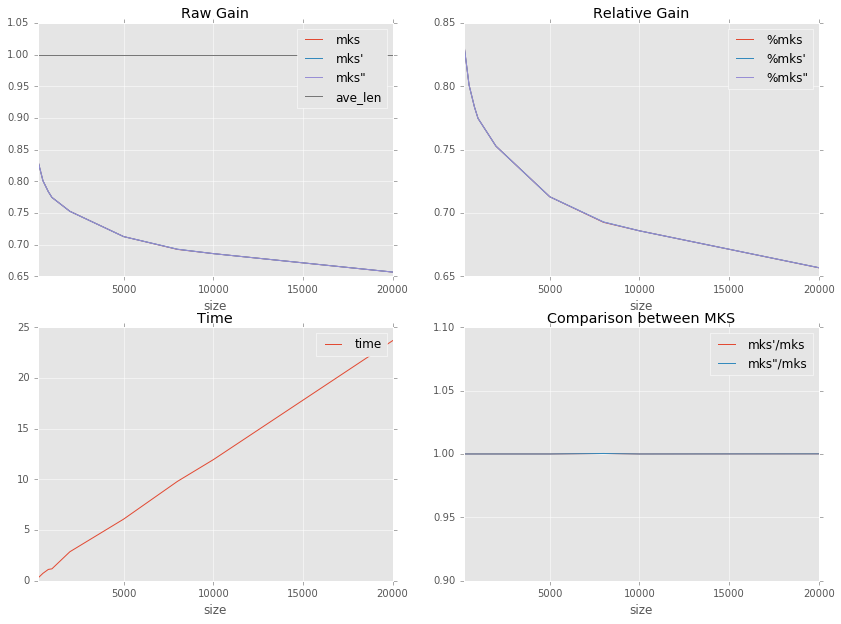

In [48]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Reduce the alphabet size

In [49]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [50]:
import time, random, pandas

def char_modulo(c, size):
    if len(c) != 1:
        raise Exception("unexpected size '%s'" % c)
    if len(c) != len(c.lower()):
        raise Exception("unexpected lower size '%s' != '%s' (%d != %d)" % (c, c.lower(), len(c), len(c.lower())))
    if size is None:
        return c
    else:
        o = ord(c.lower())
        a = 97
        d = (o - a) + size * 10
        return chr(97  + (d % size))

def reduce_alphabet(sample, size):
    return ["".join(char_modulo(c, size) for c in word) for word in sample]

def benchmark_size(size, alphabet_sizes):
    if size is None:
        size = len(list_titles)
        sample = list_titles
    else:
        sample = random.sample(list_titles, size)
    print("time", 0)
    allres = []
    for size in alphabet_sizes:
        begin = time.clock()
        spl = reduce_alphabet(sample, size)
        spl = list(sorted(set(spl)))
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        if size is None:
            size = max(_ for _ in alphabet_sizes if _ is not None) + 5
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark_size(5000, [None] + list(range(2, 26)))
df.tail(n=2)

time 0
time: 7.253531408064191s - nb=5000 gain (0.7150871219502191, 0.7150871219502191, 0.7150871219502191, 1.0)
time: 4.168262742233765s - nb=4599 gain (0.4118058499364177, 0.41556803730394604, 0.4194891903348914, 1.0)
time: 5.363930459741368s - nb=4942 gain (0.5551072917202682, 0.5571862296094259, 0.5578140276848647, 1.0)
time: 6.043614899479962s - nb=4969 gain (0.5961293241742387, 0.5999341861708662, 0.6001398543869004, 1.0)
time: 5.918027970736148s - nb=4993 gain (0.6356667111380256, 0.6356872363789408, 0.6356872363789408, 1.0)
time: 6.007594793803037s - nb=4994 gain (0.6465318186016393, 0.6475067475344511, 0.6475888468130038, 1.0)
time: 6.027530699901035s - nb=4995 gain (0.6622195767738779, 0.6623324644403873, 0.6623324644403873, 1.0)
time: 6.134441534627058s - nb=4996 gain (0.6696193956314656, 0.6696193956314656, 0.6696193956314656, 1.0)
time: 5.953909522742379s - nb=4996 gain (0.6824347897469581, 0.6824450509984203, 0.6824450509984203, 1.0)
time: 6.223897600284545s - nb=4998 gai

,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
23,24,6.488182,0.710954,0.710954,0.710954,1.0,0.710954,1.0,0.710954,1.0,0.710954,1.0
24,25,6.496471,0.712206,0.712206,0.712206,1.0,0.712206,1.0,0.712206,1.0,0.712206,1.0


In [51]:
df = df.sort_values("size")

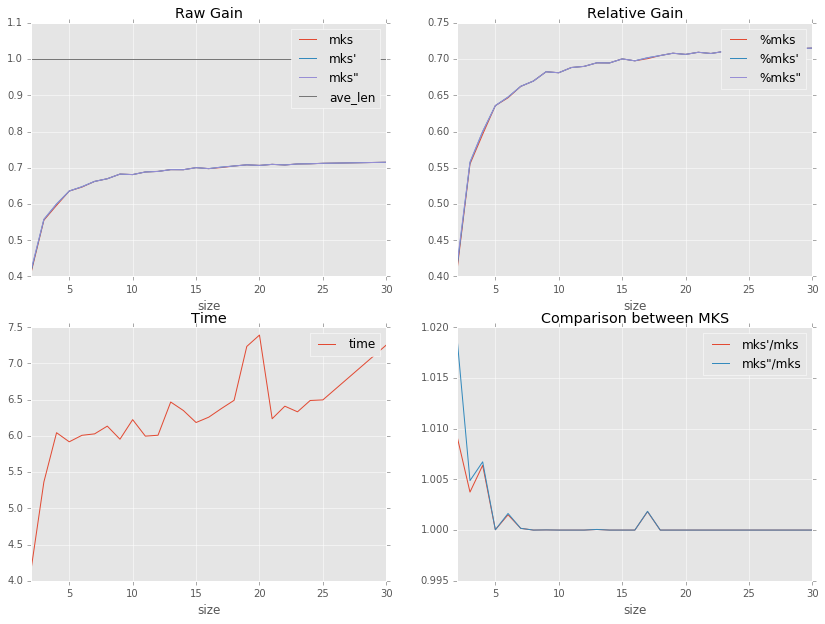

In [52]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
#ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [53]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 57.05719786319423s - nb=50000 gain (0.6152448600433221, 0.6153803516623444, 0.6153803516623444, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,57.057198,0.615245,0.61538,0.61538,1.0,0.615245,1.0,0.61538,1.00022,0.61538,1.00022


In [ ]:
df2 = benchmark([50000, 100000, 200000, 500000, 500000, 1000000, 2000000, None])
df2.tail(n=2)

In [ ]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14,10))
dfall.plot(x="size", y="time", ax=ax[1,0])
dfall.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
dfall.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
dfall.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")